Take Home Assignment 3

3.0 Install any dependencies if needed 


In [ ]:
%pip install supervision
%pip install ultralytics

In [2]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [3]:
img = cv2.imread("demo5_images/cars1.jpg")


0: 416x640 14 cars, 420.6ms
Speed: 13.7ms preprocess, 420.6ms inference, 57.3ms postprocess per image at shape (1, 3, 416, 640)


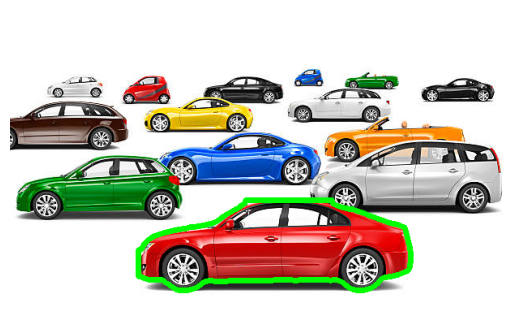

In [4]:
# Run a segmentation model on the image 

# Iterate through the boxes in the results object 
    # For each box , obtain the coordinates of the box, evaluate area
    # Find out the index of the box with the largest area

# Draw the mask of the box with the largest area. 


# Load the image
img_path = "demo5_images/cars1.jpg"
img = cv2.imread(img_path)

# Load a YOLO segmentation model (Replace 'yolov8n-seg.pt' with your model file)
model = YOLO("yolov8n-seg.pt")

# Run the segmentation model on the image
results = model(img)[0]  # Get the first result from the list

largest_area = 0
largest_mask = None

# Iterate through the detected masks and find the largest one
for mask in results.masks.xy:
    mask_contour = np.array(mask, dtype=np.int32)
    area = cv2.contourArea(mask_contour)
    if area > largest_area:
        largest_area = area
        largest_mask = mask_contour

 # Draw the largest mask on the image
if largest_mask is not None:
    cv2.drawContours(img, [largest_mask], -1, (0, 255, 0), 5)

# Display the result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show() 


3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 488.9ms
Speed: 11.5ms preprocess, 488.9ms inference, 72.0ms postprocess per image at shape (1, 3, 416, 640)


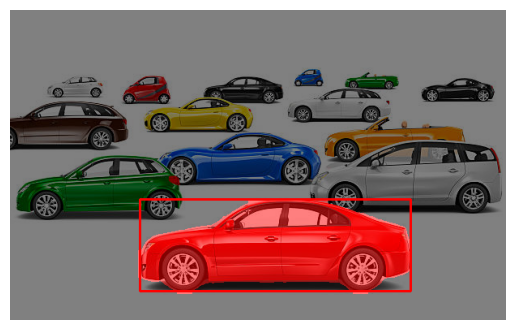

True

In [7]:
# Run a segmentation model on the image using ultralytics libraries & a model of your choice

# Transfer ultralytics results to supervision

# Iterate through the masks & find the largest

# Display the largest 


# Load the image
img_path = "demo5_images/cars1.jpg"
img = cv2.imread(img_path)


# Load the YOLO segmentation model
model_path = "yolo11n-seg.pt"
yolo_model = YOLO(model_path)

# Run the segmentation model on the image
results = yolo_model(img)

#convert the results to supervision format
largest_area = 0
largest_mask = None
largest_box = None

detections = sv.Detections.from_ultralytics(results[0])

# Find the largest car mask and bounding box
if detections.mask is not None and len(detections.mask) > 0:
    for i, (box, mask) in enumerate(zip(detections.xyxy, detections.mask)):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        area = width * height
        
        # Find the largest detected car
        if area > largest_area:
            largest_area = area
            largest_mask = mask
            largest_box = (int(x1), int(y1), int(x2), int(y2))

# Draw the largest mask if found
if largest_mask is not None:
    mask_np = np.array(largest_mask, dtype=np.float32)
    mask_np = mask_np.astype(np.uint8)  # Convert to uint8
    mask_np = cv2.resize(mask_np, (img.shape[1], img.shape[0]))  # Resize to match image size
    mask_colored = np.zeros_like(img)
    mask_colored[mask_np > 0] = (0, 0, 255)  # Apply green mask
    
    # Overlay mask on the image
    img = cv2.addWeighted(mask_colored, 0.5, img, 1 - 0.5, 0)
    
    # Draw bounding box
    if largest_box is not None:
        x1, y1, x2, y2 = largest_box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0,255), 2)  # Blue bounding box

# Convert BGR to RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show and save the output
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()
cv2.imwrite("largest_car_mask_supervision.jpg", img)



3.2 Estimate distance to centroid of chair 

xFormers not available
xFormers not available


100%|██████████| 18.4M/18.4M [05:44<00:00, 56.0kB/s]



0: 384x640 1 chair, 689.6ms
Speed: 66.4ms preprocess, 689.6ms inference, 38.3ms postprocess per image at shape (1, 3, 384, 640)
Estimated depth at chair centroid: 0.0


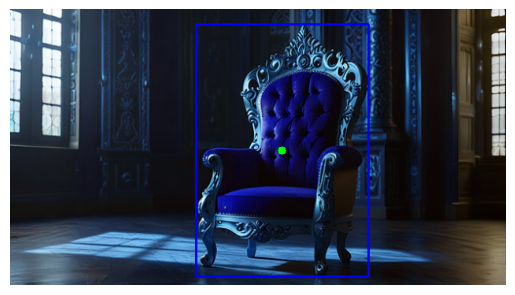

In [40]:
# Detect the chair in the image  - A detection model of your choice can be used

# Calculate the centroid of the chair - Access box coordinates from the detection model and calculate the centroid

# Obtain the depth map - Depth Anything V2 can be used 

# Query the value of the depth map at the centroid's location

from depth_anything_v2.dpt import DepthAnythingV2
import torchvision.transforms as transforms

# Load the image
img_path = "demo5_images/kingChair.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Error loading image: {img_path}")

# Convert BGR image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ensure image dimensions are multiples of 14
H, W, _ = img_rgb.shape
new_H = (H // 14) * 14  # Round down to the nearest multiple of 14
new_W = (W // 14) * 14  # Round down to the nearest multiple of 14
img_rgb = cv2.resize(img_rgb, (new_W, new_H))

# Load YOLO11 object detection model
detection_model = YOLO("yolo11s.pt")

# Perform object detection
results = detection_model(img_rgb)

# Find the centroid of the detected chair
centroid_x, centroid_y = None, None
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
        label = result.names[int(box.cls[0])]
        if "chair" in label.lower():
            centroid_x = int((x1 + x2) / 2)
            centroid_y = int((y1 + y2) / 2)
            # Draw bounding box
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box
            break
    if centroid_x is not None:
        break

if centroid_x is None or centroid_y is None:
    raise ValueError("No chair detected in the image.")

# Load Depth Anything V2 model for depth estimation
depth_model = DepthAnythingV2()

# Convert image to PyTorch tensor with correct shape
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts (H, W, C) to (C, H, W)
])
img_tensor = transform(img_rgb).unsqueeze(0)  # Add batch dimension (1, C, H, W)

# Run depth estimation
with torch.no_grad():
    depth_map = depth_model(img_tensor).squeeze(0).cpu().numpy()  # Convert back to NumPy

# Query depth at the centroid
chair_depth = depth_map[centroid_y, centroid_x]
print(f"Estimated depth at chair centroid: {chair_depth}")

# Draw centroid on the image
cv2.circle(img_rgb, (centroid_x, centroid_y), 5, (0, 255, 0), -1)  # Green dot

# Display the image with bounding box and centroid
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [8]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
%pip install gdown
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: h:\based on university\4th year\8th semester\Mechine vision\Assignments\b5_tha3_456\vehicles_video.mp4
100%|██████████| 35.3M/35.3M [02:24<00:00, 244kB/s]


'vehicles_video.mp4'

In [9]:
model = YOLO("yolo11n.pt")


def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Complete this function

    sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [10]:
# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.RED)

# Initialize tracker
tracker = sv.ByteTrack()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Track detections
    detections = tracker.update_with_detections(detections)
    
    # Prepare labels
    labels = [f"ID: {tracker_id}" for tracker_id in detections.tracker_id]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    # Annotate labels separately with bold black text and larger size
    font_scale = 1.5  # Increase the font scale to make the text larger
    font_thickness = 2  # Thickness of the text
    for i, label in enumerate(labels):
        # Coordinates for the label
        x, y = int(detections.xyxy[i][0]), int(detections.xyxy[i][1]) - 10
        
        # Simulate bold text by drawing the text multiple times with slight offsets
        frame = cv2.putText(frame, label, (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Shadow
        frame = cv2.putText(frame, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), font_thickness, cv2.LINE_AA)  # Bold black
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_id.mp4",
    callback=callback
)




0: 384x640 3 cars, 1 truck, 672.9ms
Speed: 99.7ms preprocess, 672.9ms inference, 49.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 667.8ms
Speed: 33.7ms preprocess, 667.8ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 424.2ms
Speed: 11.4ms preprocess, 424.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 247.3ms
Speed: 7.0ms preprocess, 247.3ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 243.9ms
Speed: 7.0ms preprocess, 243.9ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 211.6ms
Speed: 6.6ms preprocess, 211.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 176.6ms
Speed: 4.3ms preprocess, 176.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 194.5ms
Speed: 6.5ms p

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [11]:

# Initialize Supervision annotator with bold green border
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.RED)

# Initialize tracker
tracker = sv.ByteTrack()

# To keep track of positions over time
track_history = {}

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Perform inference
    results = model(frame)[0]
    
    # Extract bounding boxes, class IDs, and confidence scores
    detections = results.boxes.xyxy.cpu().numpy()  # Bounding boxes
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    
    # Create Supervision Detections object
    detections = sv.Detections(xyxy=detections, confidence=confidences, class_id=class_ids)
    
    # Filter detections to only include 'car' class (assuming class_id 2 for cars, check model labels)
    car_class_id = 2
    mask = detections.class_id == car_class_id
    detections = detections[mask]
    
    # Track detections
    detections = tracker.update_with_detections(detections)
    
    # Prepare labels
    labels = [f"ID: {tracker_id}" for tracker_id in detections.tracker_id]
    
    # Annotate frame with bold green bounding boxes
    frame = box_annotator.annotate(frame, detections)
    
    # Annotate labels separately with bold black text and larger size
    font_scale = 1.0  # Increase the font scale to make the text larger
    font_thickness = 2  # Thickness of the text
    for i, label in enumerate(labels):
        # Coordinates for the label
        x, y = int(detections.xyxy[i][0]), int(detections.xyxy[i][1]) - 10
        
        # Simulate bold text by drawing the text multiple times with slight offsets
        frame = cv2.putText(frame, label, (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Shadow
        frame = cv2.putText(frame, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)  # Bold black
    
    # Draw track traces (paths) for the tracked cars
    for i, tracker_id in enumerate(detections.tracker_id):
        car_id = int(tracker_id)
        
        # Get current car position
        car_position = (int(detections.xyxy[i][0] + (detections.xyxy[i][2] - detections.xyxy[i][0]) / 2),
                        int(detections.xyxy[i][1] + (detections.xyxy[i][3] - detections.xyxy[i][1]) / 2))  # Center of the bounding box
        
        # If the tracker_id has been seen before, add the position to its history
        if car_id not in track_history:
            track_history[car_id] = []
        track_history[car_id].append(car_position)
        
        # Draw the track trace (path) for the car
        if len(track_history[car_id]) > 1:
            # Draw the path by connecting points
            for j in range(1, len(track_history[car_id])):
                cv2.line(frame, track_history[car_id][j-1], track_history[car_id][j], (0, 0, 255), 2)  # Green trace
    
    return frame

# Process video with supervision
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking_with_trace.mp4",
    callback=callback
)



0: 384x640 3 cars, 1 truck, 231.3ms
Speed: 7.0ms preprocess, 231.3ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 205.2ms
Speed: 5.5ms preprocess, 205.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 166.4ms
Speed: 6.3ms preprocess, 166.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 188.8ms
Speed: 6.4ms preprocess, 188.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 246.6ms
Speed: 26.8ms preprocess, 246.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 347.0ms
Speed: 5.0ms preprocess, 347.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 209.9ms
Speed: 10.6ms preprocess, 209.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 287.4ms
Speed: 5.4ms pre

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

The function definition def callback(frame: np.ndarray, _: int) -> np.ndarray: is designed for use in situations where the function is called repeatedly, such as in video processing or real-time data handling. Here's a breakdown of what it does:

1. Callback Function:
    The function is called a callback, meaning it gets triggered automatically when an event happens (like receiving a new frame of video or data).For example, in video processing, it could process each frame as it's received.


2. Parameters:
    (frame: np.ndarray:) This is the first input, a NumPy array that represents an image or video frame. It holds the pixel data of the image.

    (_: int:) The second input is an integer (e.g., a frame number or timestamp), but it's not used in the function. The underscore (_) is a Python convention to show that this value is ignored.


3. Return Type:
    (-> np.ndarray:) This tells us that the function will return a NumPy array. So, it processes the frame and gives back a modified version of it.


How it works:
The function is used in situations where frames or data are processed as they come in. It takes the frame, does some kind of processing (like filtering or transformations), and returns the modified frame.

Example use:
1. Image/Video Processing: In video processing, each frame is passed to this function, which could:

    Apply effects like blurring or edge detection
    
    Convert the frame to grayscale
    
    Perform other image transformations (like rotating or resizing) After processing, the modified frame is either displayed or used for the next steps.

2. Real-time Data Processing: In real-time systems (like robotics or surveillance), this function could handle data like camera frames as they come in. The second parameter (the integer) might represent a timestamp or sequence number, but it’s not used for the actual processing.


Summery:
    
    The callback function processes frames or data (like video frames) that arrive in real-time.
    
    It takes a frame (as a NumPy array) and an unused parameter, modifies the frame, and returns the updated version.
    
    The underscore (_) just indicates that the second input isn’t needed for the processing part.

Answers: Complete this section